# Manual separation of the large cloud

As we have two large clouds that seem to overlap each other in velocity, we will do the following:
- Load the 1 Gaussian (AIC filtered) cube
- Load the 2 Gaussian cube
- For each empty pixel, choose the component that has the closest velocity to its neighbors. We need to choose a direction to start
- When it ends, one of the components will be ignored that is also in the cloud. We look for it (this is the fork in velocities)

This last point might not be a problem after the Nested Sampling

In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import os
import sys
sys.path.append('../')
from setup import *
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
%matplotlib widget

In [2]:
feature_table = 'feature_table_aic.csv'
normalize=True


In [3]:

params1g, params1gheader = fits.getdata(fitfilebase.format(1)+'_aic.fits', header=True)
wcs = WCS(params1gheader).celestial
params2g = fits.getdata(fitfilebase.format(2)+'_aic.fits')
ncomponents = fits.getdata(fitdir+'diagnosticAIC/ncomponents_AIC.fits')
ncomponents[np.where(np.isnan(ncomponents))] = 0

In [4]:
xarray = np.linspace(0, params1gheader['NAXIS1']-1, params1gheader['NAXIS1'])
yarray = np.linspace(0, params1gheader['NAXIS2']-1, params1gheader['NAXIS2'])
xx, yy = np.meshgrid(xarray, yarray)

amplitudes = np.array([params1g[0], params2g[0], params2g[3]])
e_amplitudes = np.array([params1g[3], params2g[6], params2g[9]])
cent_velocities = np.array([params1g[1], params2g[1], params2g[4]])
e_cent_velocities = np.array([params1g[4], params2g[7], params2g[10]])
sigma_vs = np.array([params1g[2], params2g[2], params2g[5]])
e_sigma_vs = np.array([params1g[5], params2g[8], params2g[11]])



In [5]:
# this should exist from the feature exploration
ds_feats = pd.read_csv(feature_table)

## Clustering using DBSCAN


In [6]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [7]:
ds_fit1 = ds_feats[['x_pix', 'y_pix', 'amplitude', 'vlsr', 'sigma_v']]

scaler1 = StandardScaler()
X1 = scaler1.fit_transform(ds_fit1)

In [8]:
min_samples = 300
# average distance between each point and its k nearest neighbors
# neighbors = NearestNeighbors(n_neighbors=min_samples, radius=2.0, algorithm='kd_tree')
# neighbors.fit(X1)
# distances, indices = neighbors.kneighbors(X1)
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]

In [9]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(distances)
# ax.set_xlabel('Points sorted by k-distance')
# ax.set_ylabel('Average distance to k='+str(min_samples)+' nearest neighbors')

In [17]:
db = DBSCAN(eps=0.35, min_samples=min_samples)
    
db.fit(X1)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Total number of points: %d" % len(labels))
unique_labels = set(labels)

Estimated number of clusters: 6
Estimated number of noise points: 30701
Total number of points: 54020


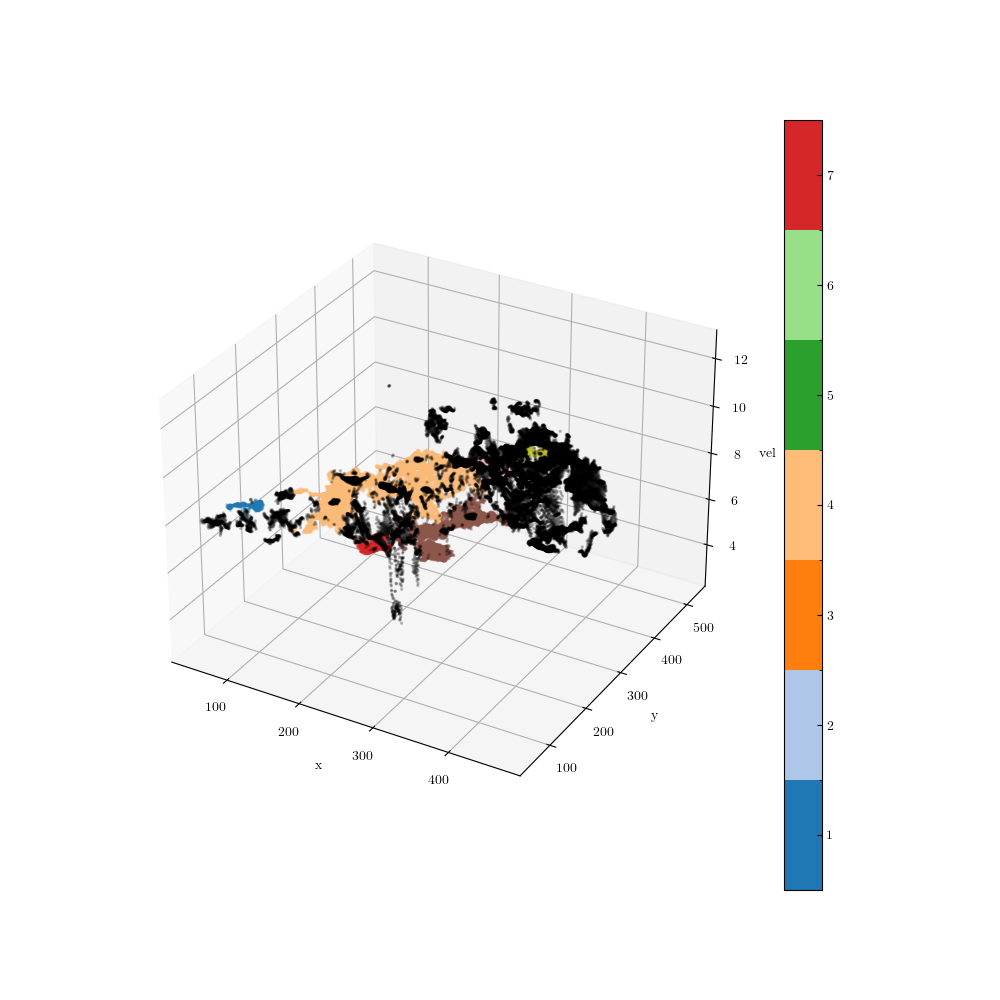

In [18]:
# lets plot little by little
ngroups = 7
c = np.arange(1., ngroups + 1)

my_cmap = plt.cm.tab20.copy()
colors = [my_cmap(each) for each in np.linspace(0, 1, ngroups)]
norm = matplotlib.colors.BoundaryNorm(np.arange(ngroups + 1)+0.5, ngroups)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('vel')

#plot first 10 groups
for k, col in zip(list(unique_labels)[:ngroups], colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        #continue

    class_member_mask = labels == k
    
    xy = scaler1.inverse_transform(X1[class_member_mask])
    ax.scatter(xy[:,0], xy[:,1], xy[:,3], s=2, color=col, alpha=0.2)
    
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
plt.colorbar(sm, ax=ax, ticks=c)

### Fit using only those feats with $\sigma_v < 0.4$ 

In [ ]:

ds_fit = ds_feats.loc[(ds_feats['sigma_v']<=0.4) & (ds_feats['vlsr']<=9.1) & (ds_feats['vlsr']>6)][['x_pix', 'y_pix', 'vlsr', 'sigma_v']]

scaler = StandardScaler()
X = scaler.fit_transform(ds_fit)

In [ ]:
min_samples = 100 # we can also use 4 but I'm not sure it makes sense with such a big sample space
# average distance between each point and its k nearest neighbors
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(distances)
ax.set_xlabel('Points sorted by k-distance')
ax.set_ylabel('Average distance to k='+str(min_samples)+' nearest neighbors')

In [ ]:
# The inflexion point in the nearest neighbors plot is around 0.14, so we can play around with an eps=0.14
db = DBSCAN(eps=0.35, min_samples=min_samples)
    
db.fit(X)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Total number of points: %d" % len(labels))

In [ ]:
unique_labels = set(labels)
colors = [plt.cm.Set1(each) for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('vel')

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        # continue


    class_member_mask = labels == k

    xy = scaler.inverse_transform(X[class_member_mask])
    ax.scatter(xy[:,0], xy[:,1], xy[:,2], color=col, alpha=0.2)

## Test: manual cut with sigma

In [ ]:
#lets first choose all components that have vel between 6 and 8.5 and sigma less than 0.4 km/s
mask1g = (params1g[2] <= 0.4) * (params1g[1] <= 9.1) * (params1g[1] >= 6)
mask2g1 = (params2g[2] <= 0.4) * (params2g[1] <= 9.1) * (params2g[1] >= 6)
mask2g2 = (params2g[5] <= 0.4) * (params2g[4] <= 9.1) * (params2g[4] >= 6)
# the velocity range is to not add noise or bad fits

mask1g = np.repeat(mask1g[np.newaxis, :, :], 6, axis=0)
mask2g = np.concatenate([[mask2g1]*3, [mask2g2]*3, [mask2g1]*3, [mask2g2]*3])


In [ ]:
params1gcloud = np.where(mask1g, params1g, np.nan)
params2gcloud = np.where(mask2g, params2g, np.nan)

In [ ]:
velocity = np.nansum([params1gcloud[1], params2gcloud[4]], axis=0)
velocity[np.where(velocity<3)] = np.nan

In [ ]:
cmap = cm.RdYlBu_r.copy()
cmap.set_bad('0.85')


# cmap2 = cm.RdYlBu_r.copy()
# cmap2.set_bad('0.85', alpha=0)

fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)
im = ax.imshow(velocity, cmap=cmap, vmin=3, vmax=10, origin='lower')
# im = ax.imshow(params2gcloud[1], cmap=cmap2, vmin=3, vmax=10, zorder=10, origin='lower')
ax.contour(velocity<7, levels=[0.5], colors='k', zorder=100)
plt.colorbar(im, ax=ax)

## Old tests: direct decomposition

In [ ]:
base_vel = params1g[1].copy() 
option_vels = np.array([params2g[1], params2g[4]])
component2g = np.zeros(np.shape(base_vel))
selected_vel = np.zeros(np.shape(base_vel)) * np.nan
rest_vel = np.zeros(np.shape(base_vel)) * np.nan

# lets test on the empty pixel x 222, y 277
# xe = 218
# ye = 277



In [ ]:
# we only do this experiment where there are 2 components!
ytest, xtest = np.where(ncomponents == 2)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for ye, xe in zip(ytest, xtest):
        radius = 1
        test_square = base_vel[ye-radius:ye+radius+1, xe-radius:xe+radius+1]
        while np.all(np.isnan(test_square)):
            radius += 1
            test_square = base_vel[ye-radius:ye+radius+1, xe-radius:xe+radius+1]
        mask = np.ones(np.shape(test_square), dtype=bool)
        mask[radius, radius] = False
        test_square_good = test_square[mask]
        veloptions = option_vels[:,ye, xe]
        optimal = np.nanmean(test_square_good)
        indexwin = np.argmin(np.abs(veloptions - optimal))
        indexlose =  np.argmax(np.abs(veloptions - optimal))
        selected_vel[ye, xe] = veloptions[indexwin]
        rest_vel[ye, xe] = veloptions[indexlose]
        component2g[ye, xe] = indexwin+1

In [ ]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)
im = ax.imshow(component2g, origin='lower')


In [ ]:
cmap = cm.RdYlBu_r.copy()
cmap.set_bad('0.85')

cmap2 = cm.RdYlBu_r.copy()
cmap2.set_bad('0.85', alpha=0)

fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)
ax.imshow(base_vel, cmap=cmap, vmin=3, vmax=10, origin='lower')
im = ax.imshow(selected_vel, cmap=cmap2, vmin=3, vmax=10, zorder=10, origin='lower')
# ax.contour(ncomponents, levels=[1.5], colors='k', zorder=100)
plt.colorbar(im, ax=ax)

In [ ]:
cmap = cm.RdYlBu_r.copy()
cmap.set_bad('0.85')

cmap2 = cm.RdYlBu_r.copy()
cmap2.set_bad('0.85', alpha=0)

fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)
ax.imshow(base_vel, cmap=cmap, vmin=3, vmax=10, origin='lower')
im = ax.imshow(rest_vel, cmap=cmap2, vmin=3, vmax=10, zorder=10, origin='lower')
# ax.contour(ncomponents, levels=[1.5], colors='k', zorder=100)
plt.colorbar(im, ax=ax)